# Task 2 Noise, Noise, and More Noise 

In [1]:
# Install necessary packages
%pip install qiskit[visualization]==1.0.2
%pip install qiskit-ibm-runtime
%pip install qiskit-aer

In [2]:
# Import libraries
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from math import pi
import numpy as np

### 1.	Noise Model 


A standard way to represent the noise in a quantum circuit is through Pauli operators (σ_x, σ_y, σ_z). Build a function with input α,β and QuantumCircuit where:

	 α → Probability of having a random Pauli operator acting on the qubit after a one-qubit gate 
	 β → Probability of having a random Pauli operator acting on the qubit after a two-qubit gate 
	QuantumCircuit → Quantum circuit where the noise will be added 

The output should be the Quantum Circuit with Noise 


In [3]:

# This function applies a random Pauli gate (X, Y, Z) to a qubit with a given probability.
def apply_pauli_noise(qc, qubit, probability):
    if np.random.rand() < probability:
        pauli = np.random.choice(['x', 'y', 'z'])
        if pauli == 'x':
            qc.x(qubit)
        elif pauli == 'y':
            qc.y(qubit)
        elif pauli == 'z':
            qc.z(qubit)

# The add_noise_to_circuit function returns a quantum circuit with noise added based on probabilities alpha and beta.
def add_noise_to_circuit(qc, alpha, beta):
#     noisy_qc = QuantumCircuit(qc.num_qubits, qc.num_clbits)  # Initialize the noisy circuit
    # Create a new circuit using the same registers as the original circuit
    noisy_qc = QuantumCircuit(*qc.qregs, *qc.cregs)  

    print(*qc.cregs)
    # Loop through each gate in the original circuit
    for instruction, qargs, cargs in qc.data:
        noisy_qc.append(instruction, qargs, cargs)  # Apply the original gate

        if len(qargs) == 1:
            apply_pauli_noise(noisy_qc, qargs[0], alpha) # add noise with probability alpha for single qubit
        elif len(qargs) == 2:
            for qubit in qargs:
                apply_pauli_noise(noisy_qc, qubit, beta) # add noise with probability beta for two qubit
    return noisy_qc

# Example for 10% and 5% chance for noise 
alpha = 0.1  
beta = 0.05   


original_qc = QuantumCircuit(2, 2)
original_qc.h(0)
original_qc.cx(0, 1)
original_qc.measure([0, 1], [0, 1])


noisy_qc = add_noise_to_circuit(original_qc, alpha, beta)

print(noisy_qc)


ClassicalRegister(2, 'c')
     ┌───┐┌───┐     ┌─┐┌───┐
q_0: ┤ H ├┤ Z ├──■──┤M├┤ X ├
     └───┘└───┘┌─┴─┐└╥┘└┬─┬┘
q_1: ──────────┤ X ├─╫──┤M├─
               └───┘ ║  └╥┘ 
c: 2/════════════════╩═══╩══
                     0   1  


### 2.	Gate Basis 

Quantum computers can implement only a set of gates that, with transformations, can represent any other possible gate. This set of gates is called the Gate Basis of the QPU. Build a function that transforms a general Quantum Circuit to the following gate basis: {CX,ID,RZ,SX,X}


In [4]:

def transform_to_basis(qc):
    """
    Transforms a quantum circuit to the specified gate basis {CX, ID, RZ, SX, X}.
    
    Parameters:
        qc (QuantumCircuit): The original quantum circuit.
    
    Returns:
        QuantumCircuit: A transformed quantum circuit using only the specified gate basis.
    """
    
    target_basis = ['cx', 'id', 'rz', 'sx', 'x'] # Define the target gate basis
    transformed_qc = transpile(qc, basis_gates=target_basis) # Transpile helps to use only the defined gate basis
    return transformed_qc

original_qc = QuantumCircuit(3)
original_qc.h(0)
original_qc.cx(0, 1)
original_qc.ccx(0, 1, 2)
original_qc.measure_all()


transformed_qc = transform_to_basis(original_qc)
print("Transformed Quantum Circuit:")
print(transformed_qc)


Transformed Quantum Circuit:
global phase: 7π/8
        ┌─────────┐┌────┐┌─────────┐                                           »
   q_0: ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├──■─────────────────────■──────────────────»
        └─────────┘└────┘└─────────┘┌─┴─┐                   │                  »
   q_1: ────────────────────────────┤ X ├──■────────────────┼───────────────■──»
        ┌─────────┐┌────┐┌─────────┐└───┘┌─┴─┐┌──────────┐┌─┴─┐┌─────────┐┌─┴─┐»
   q_2: ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─────┤ X ├┤ Rz(-π/4) ├┤ X ├┤ Rz(π/4) ├┤ X ├»
        └─────────┘└────┘└─────────┘     └───┘└──────────┘└───┘└─────────┘└───┘»
meas: 3/═══════════════════════════════════════════════════════════════════════»
                                                                               »
«                                     ┌─────────┐             ░ ┌─┐      
«   q_0: ──────────────■───────■──────┤ Rz(π/4) ├──────■──────░─┤M├──────
«        ┌─────────┐   │     ┌─┴─┐    ├─────────┴┐   ┌─┴─┐    ░ └╥┘┌─┐   
«

### 3.	Adding two numbers with a quantum computer

Build a function (quantum_sum) to add two numbers using the Draper adder algorithm. You will need the Quantum Fourier Transform (QFT). Many libraries offer a function to use it. For this task, you will need to build QFT from scratch.


In [11]:
# Step 1: Convert A and B to binary and store in the qubits
def convert_AB_to_binary(circuit, a, b, a_value=15, b_value=5):
    
    # Convert `a_value` to binary  with leading zeros for a's length and apply X gates where bits are 1
    a_bits = f"{a_value:0{len(a)}b}"  
    for i, bit in enumerate(reversed(a_bits)):  # Reorder the qubit
        if bit == '1':
            circuit.x(a[i])
    
    # Convert `b_value` to binary  with leading zeros for b's length and apply X gates where bits are 1
    b_bits = f"{b_value:0{len(b)}b}"  
    for i, bit in enumerate(reversed(b_bits)):  
        if bit == '1':
            circuit.x(b[i])

# Step 2: Apply QFT on B and cout
def qft(circuit, b, cout):
    circuit.h(cout[0])
    # Controlled phase rotations from b to cout
    for i, qubit in enumerate(reversed(b)):
        circuit.cp(pi / (2 ** (i + 1)), qubit, cout[0])

    # Apply the QFT structure on b
    for i in range(len(b)):
        circuit.h(b[len(b) - 1 - i])
        for j in range(i + 1, len(b)):
            circuit.cp(pi / (2 ** (j - i)), b[len(b) - 1 - j], b[len(b) - 1 - i])    

# Step 3: Apply controlled rotations from A to B
def controlled_rotations_AB(circuit, a, b, cout):
    for i, control in enumerate(a):
        for j, target in enumerate(b[i:], start=i):  # Start at the current control index to match phase pattern
            circuit.cp(pi / (2 ** (j - i)), control, target)

        # Apply to carryout (cout) 
        if cout is not None:
            circuit.cp(pi / (2 ** (len(b) - i)), control, cout[0])

# Step 4: Apply the inverse QFT on B and cout
def inverse_qft(circuit, b, cout):
    for i in range(len(b)):
        circuit.h(b[i])
        for j in range(i + 1, len(b)):
            circuit.cp(-pi / (2 ** (j - i)), b[i], b[j])
        
        # Apply controlled rotations from `b[i]` to `cout` with decreasing angles
        if cout is not None:
            circuit.cp(-pi / (2 ** (len(b) - i)), b[i], cout[0])
    
    # Apply a final Hadamard on `cout`
    if cout is not None:
        circuit.h(cout[0])

# Step 5: Measure B and cout registers
def measure_registers(circuit, b, cout, sum_register):
    circuit.measure(b, sum_register[:len(b)])
    if cout is not None:
        circuit.measure(cout, sum_register[len(b):len(b) + len(cout)])
        
# Main function to perform the quantum sum using the Draper adder algorithm
def quantum_sum(a_value=15, b_value=5, num_qubits=6):
    """
    Perform the addition of two integers using the Draper adder algorithm with QFT.
    
    Parameters:
    - a_value: Integer value to initialize in register A.
    - b_value: Integer value to initialize in register B.
    - num_qubits: Number of qubits for registers A and B.
    """
    # Define quantum and classical registers
    a = QuantumRegister(num_qubits, 'A')
    b = QuantumRegister(num_qubits, 'B')
    cout = QuantumRegister(1, 'C_out')
    sum_register = ClassicalRegister(num_qubits + 1, 'sum')
    circuit = QuantumCircuit(a, b, cout, sum_register)

    # Initialize registers `a` and `b` with binary values of A and B 
    convert_AB_to_binary(circuit, a, b, a_value, b_value)
    
    # Apply each step of the Draper adder
    qft(circuit, b, cout)
    controlled_rotations_AB(circuit, a, b, cout)
    inverse_qft(circuit, b, cout)
    measure_registers(circuit, b, cout, sum_register)
    
    # Simulate the circuit
    simulator = Aer.get_backend('qasm_simulator')
    result = simulator.run(circuit, shots=1024).result()
    counts = result.get_counts(circuit)
    
    # Print the measurement results
    print("Measured Results:")
    for binary_result, count in counts.items():
        decimal_result = int(binary_result, 2)
        print(f"Binary: {binary_result}, Count: {count}, Decimal a({a_value}) + b({b_value}) = {decimal_result}")
    
    plot_histogram(counts)
    plt.show()
    

    print("Quantum Circuit for Quantum Addition using Draper Adder:")
    print(circuit)

# usage of the quantum_sum function. If a and b values are not passed directly it will calculate 15 + 5 by default.
quantum_sum(a_value=30, b_value=17, num_qubits=6)
# quantum_sum(num_qubits=6)


Measured Results:
Binary: 0101111, Count: 1024, Decimal a(30) + b(17) = 47
Quantum Circuit for Quantum Addition using Draper Adder:
                                                                             »
  A_0: ──────────────────────────────────────────────────────────────────────»
       ┌───┐                                                                 »
  A_1: ┤ X ├─────────────────────────────────────────────────────────────────»
       ├───┤                                                                 »
  A_2: ┤ X ├─────────────────────────────────────────────────────────────────»
       ├───┤                                                                 »
  A_3: ┤ X ├─────────────────────────────────────────────────────────────────»
       ├───┤                                                                 »
  A_4: ┤ X ├─────────────────────────────────────────────────────────────────»
       └───┘                                                                 »

### 4.	Effects of noise on quantum addition 

Now, we can combine all the functions. Transform the circuit used in the quantum_sum to the gate basis and add noise. Use different levels of noise and analyze the results. 




In [6]:
def quantum_sum_with_return(a_value=15, b_value=5, num_qubits=6):
    """
    Modified version of quantum_sum that returns the circuit instead of running it (simulating the result).
    """
    a = QuantumRegister(num_qubits, 'A')
    b = QuantumRegister(num_qubits, 'B')
    cout = QuantumRegister(1, 'C_out')
    sum_register = ClassicalRegister(num_qubits + 1, 'sum')
    circuit = QuantumCircuit(a, b, cout, sum_register)

    # Initialize registers `a` and `b` with specific values
    convert_AB_to_binary(circuit, a, b, a_value, b_value)
    
    # Apply each step of the Draper adder
    qft(circuit, b, cout)
    controlled_rotations_AB(circuit, a, b, cout)
    inverse_qft(circuit, b, cout)
    measure_registers(circuit, b, cout, sum_register)
    
    
    return circuit


quantum_sum_with_return(a_value=30, b_value=17, num_qubits=6)


In [8]:
def plot_custom_histogram(counts, title="Histogram"):
    # Manually plot histogram based on the counts
    labels, values = zip(*counts.items())
    values = [v / sum(values) for v in values]  # Find probability

    plt.figure(figsize=(12, 6))  
    plt.bar(labels, values)
    plt.xlabel("Measurement Outcome")
    plt.ylabel("Probability")
    plt.title(title)
    plt.xticks(rotation=90, ha="center", va="top")  # Keep labels vertical and center-aligned
    plt.tight_layout()  
    plt.show()


ClassicalRegister(7, 'sum')
Results with α = 0.01, β = 0.01:
Binary: 0101111, Count: 650, Decimal a(30) + b(17) = 47
Binary: 1101111, Count: 374, Decimal a(30) + b(17) = 111


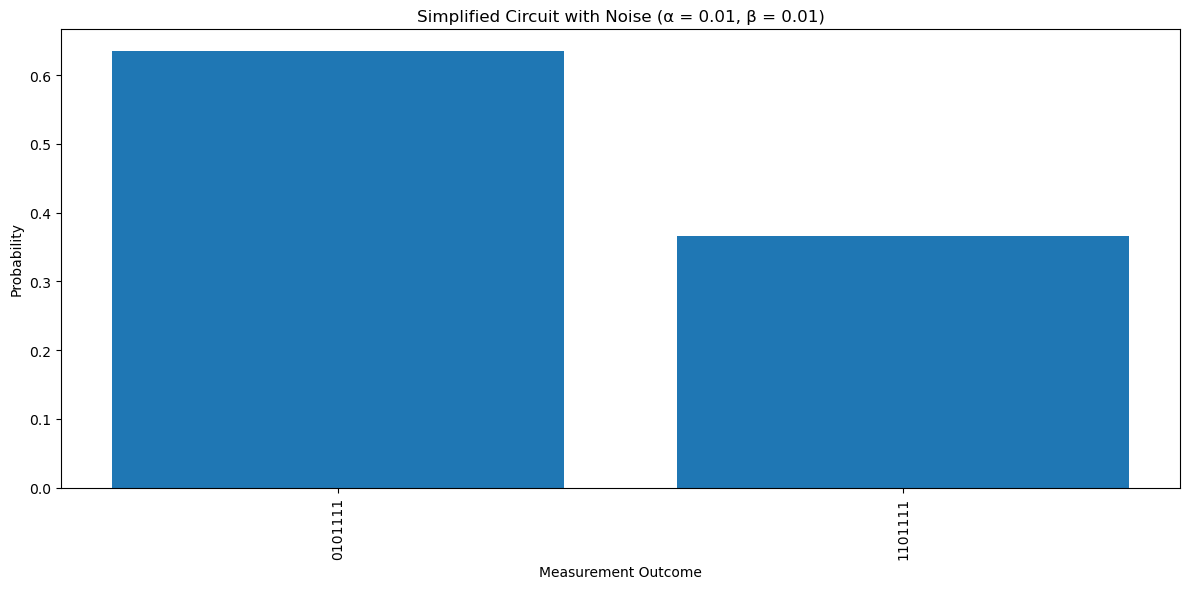

ClassicalRegister(7, 'sum')
Results with α = 0.01, β = 0.05:
Binary: 0101001, Count: 12, Decimal a(30) + b(17) = 41
Binary: 1100101, Count: 324, Decimal a(30) + b(17) = 101
Binary: 1110001, Count: 105, Decimal a(30) + b(17) = 113
Binary: 0000101, Count: 30, Decimal a(30) + b(17) = 5
Binary: 1101001, Count: 224, Decimal a(30) + b(17) = 105
Binary: 1100001, Count: 65, Decimal a(30) + b(17) = 97
Binary: 1000001, Count: 32, Decimal a(30) + b(17) = 65
Binary: 1000101, Count: 75, Decimal a(30) + b(17) = 69
Binary: 1001001, Count: 30, Decimal a(30) + b(17) = 73
Binary: 0110101, Count: 25, Decimal a(30) + b(17) = 53
Binary: 0110001, Count: 18, Decimal a(30) + b(17) = 49
Binary: 1110101, Count: 41, Decimal a(30) + b(17) = 117
Binary: 0100101, Count: 11, Decimal a(30) + b(17) = 37
Binary: 0000001, Count: 27, Decimal a(30) + b(17) = 1
Binary: 0001001, Count: 3, Decimal a(30) + b(17) = 9
Binary: 1010101, Count: 2, Decimal a(30) + b(17) = 85


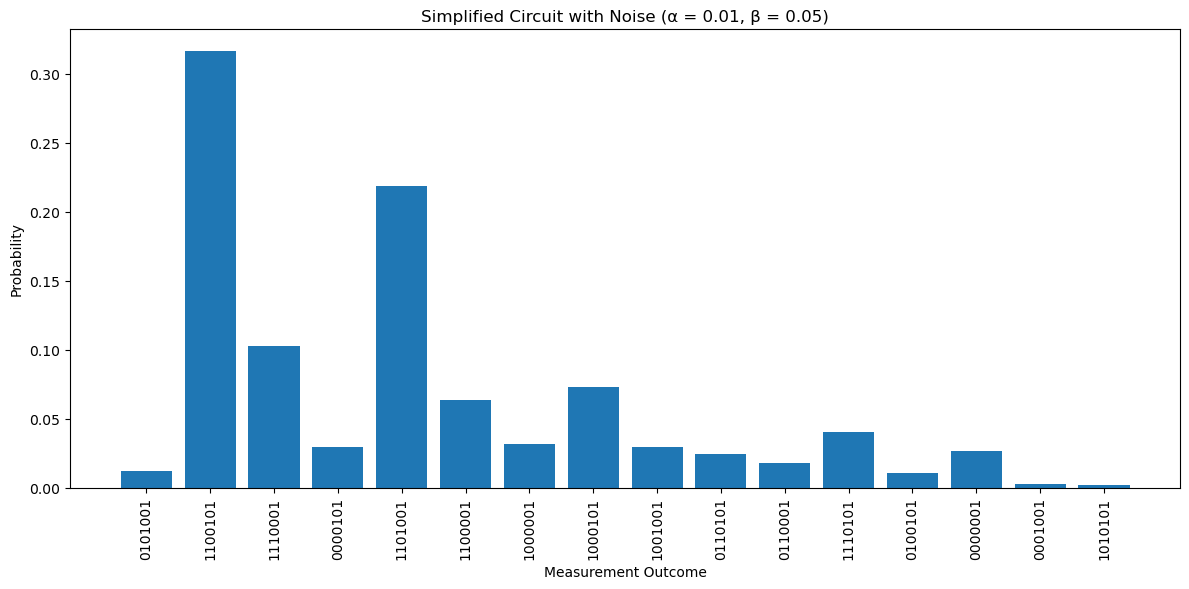

ClassicalRegister(7, 'sum')
Results with α = 0.01, β = 0.1:
Binary: 0000110, Count: 24, Decimal a(30) + b(17) = 6
Binary: 1111110, Count: 43, Decimal a(30) + b(17) = 126
Binary: 0100110, Count: 202, Decimal a(30) + b(17) = 38
Binary: 0000010, Count: 64, Decimal a(30) + b(17) = 2
Binary: 0100010, Count: 278, Decimal a(30) + b(17) = 34
Binary: 0111110, Count: 101, Decimal a(30) + b(17) = 62
Binary: 0001110, Count: 38, Decimal a(30) + b(17) = 14
Binary: 0110010, Count: 42, Decimal a(30) + b(17) = 50
Binary: 0101110, Count: 41, Decimal a(30) + b(17) = 46
Binary: 1000010, Count: 124, Decimal a(30) + b(17) = 66
Binary: 1001110, Count: 29, Decimal a(30) + b(17) = 78
Binary: 1000110, Count: 27, Decimal a(30) + b(17) = 70
Binary: 1100010, Count: 5, Decimal a(30) + b(17) = 98
Binary: 0010010, Count: 1, Decimal a(30) + b(17) = 18
Binary: 1110010, Count: 1, Decimal a(30) + b(17) = 114
Binary: 0011110, Count: 3, Decimal a(30) + b(17) = 30
Binary: 1100110, Count: 1, Decimal a(30) + b(17) = 102


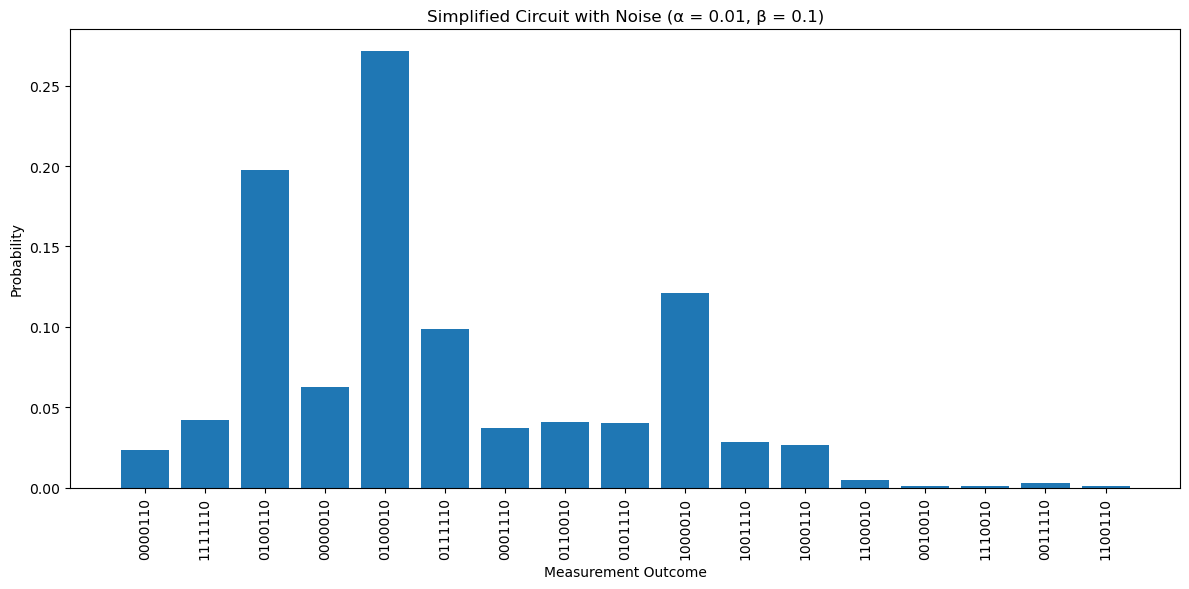

ClassicalRegister(7, 'sum')
Results with α = 0.05, β = 0.01:
Binary: 0110010, Count: 144, Decimal a(30) + b(17) = 50
Binary: 0101110, Count: 12, Decimal a(30) + b(17) = 46
Binary: 1000100, Count: 10, Decimal a(30) + b(17) = 68
Binary: 0000010, Count: 84, Decimal a(30) + b(17) = 2
Binary: 0101100, Count: 9, Decimal a(30) + b(17) = 44
Binary: 0110100, Count: 62, Decimal a(30) + b(17) = 52
Binary: 0100100, Count: 85, Decimal a(30) + b(17) = 36
Binary: 1000010, Count: 14, Decimal a(30) + b(17) = 66
Binary: 0000100, Count: 119, Decimal a(30) + b(17) = 4
Binary: 0110000, Count: 22, Decimal a(30) + b(17) = 48
Binary: 0001010, Count: 3, Decimal a(30) + b(17) = 10
Binary: 1110010, Count: 128, Decimal a(30) + b(17) = 114
Binary: 0100010, Count: 54, Decimal a(30) + b(17) = 34
Binary: 1110100, Count: 110, Decimal a(30) + b(17) = 116
Binary: 1100010, Count: 12, Decimal a(30) + b(17) = 98
Binary: 1100100, Count: 27, Decimal a(30) + b(17) = 100
Binary: 0100110, Count: 13, Decimal a(30) + b(17) = 38
B

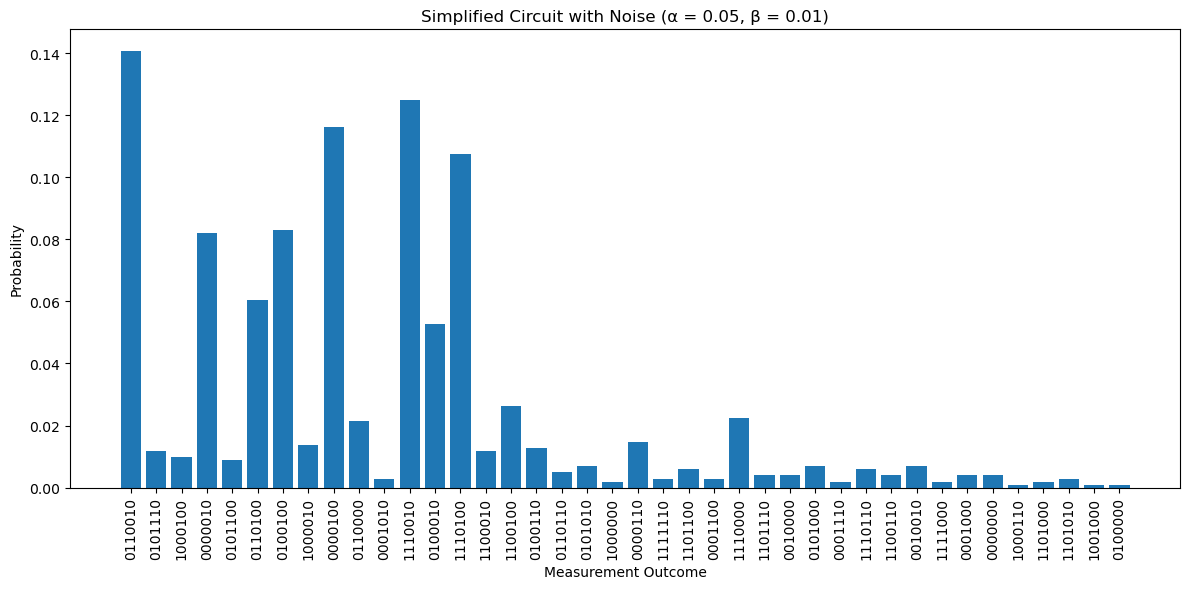

ClassicalRegister(7, 'sum')
Results with α = 0.05, β = 0.05:
Binary: 1001101, Count: 3, Decimal a(30) + b(17) = 77
Binary: 1110001, Count: 17, Decimal a(30) + b(17) = 113
Binary: 0001011, Count: 89, Decimal a(30) + b(17) = 11
Binary: 0010011, Count: 186, Decimal a(30) + b(17) = 19
Binary: 0011011, Count: 60, Decimal a(30) + b(17) = 27
Binary: 0011001, Count: 11, Decimal a(30) + b(17) = 25
Binary: 0010001, Count: 314, Decimal a(30) + b(17) = 17
Binary: 1001011, Count: 3, Decimal a(30) + b(17) = 75
Binary: 0001101, Count: 49, Decimal a(30) + b(17) = 13
Binary: 0110011, Count: 23, Decimal a(30) + b(17) = 51
Binary: 1110101, Count: 1, Decimal a(30) + b(17) = 117
Binary: 0001111, Count: 56, Decimal a(30) + b(17) = 15
Binary: 0001001, Count: 46, Decimal a(30) + b(17) = 9
Binary: 0000001, Count: 1, Decimal a(30) + b(17) = 1
Binary: 1111011, Count: 52, Decimal a(30) + b(17) = 123
Binary: 0111011, Count: 22, Decimal a(30) + b(17) = 59
Binary: 0110001, Count: 29, Decimal a(30) + b(17) = 49
Binar

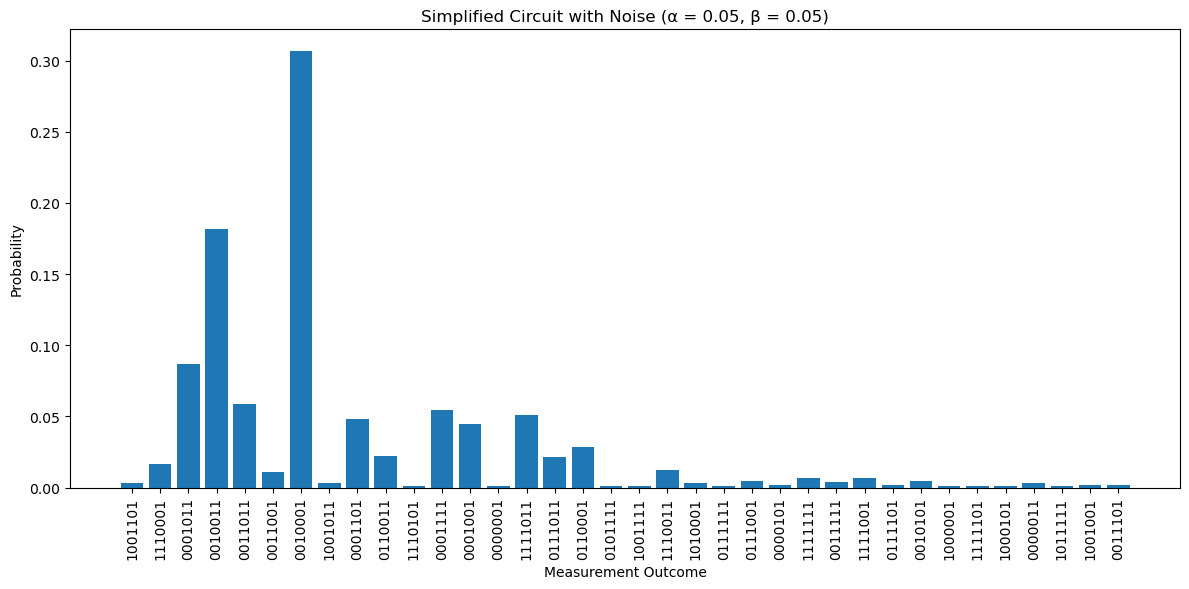

ClassicalRegister(7, 'sum')
Results with α = 0.05, β = 0.1:
Binary: 1010001, Count: 129, Decimal a(30) + b(17) = 81
Binary: 1110011, Count: 184, Decimal a(30) + b(17) = 115
Binary: 1010011, Count: 161, Decimal a(30) + b(17) = 83
Binary: 1000001, Count: 83, Decimal a(30) + b(17) = 65
Binary: 1111101, Count: 71, Decimal a(30) + b(17) = 125
Binary: 1111001, Count: 44, Decimal a(30) + b(17) = 121
Binary: 1001101, Count: 1, Decimal a(30) + b(17) = 77
Binary: 1110001, Count: 105, Decimal a(30) + b(17) = 113
Binary: 1111111, Count: 29, Decimal a(30) + b(17) = 127
Binary: 1000011, Count: 31, Decimal a(30) + b(17) = 67
Binary: 0110011, Count: 34, Decimal a(30) + b(17) = 51
Binary: 0111111, Count: 4, Decimal a(30) + b(17) = 63
Binary: 0110111, Count: 4, Decimal a(30) + b(17) = 55
Binary: 1000111, Count: 21, Decimal a(30) + b(17) = 71
Binary: 0110001, Count: 13, Decimal a(30) + b(17) = 49
Binary: 0010001, Count: 25, Decimal a(30) + b(17) = 17
Binary: 1011001, Count: 6, Decimal a(30) + b(17) = 89


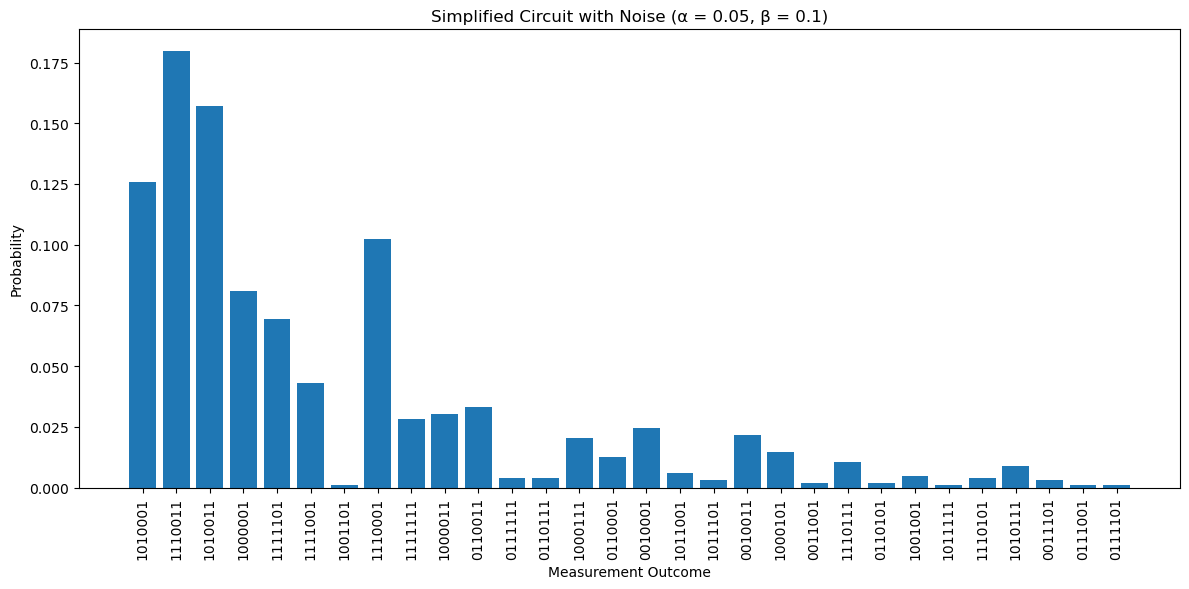

ClassicalRegister(7, 'sum')
Results with α = 0.1, β = 0.01:
Binary: 1011111, Count: 178, Decimal a(30) + b(17) = 95
Binary: 0100001, Count: 28, Decimal a(30) + b(17) = 33
Binary: 1100101, Count: 64, Decimal a(30) + b(17) = 101
Binary: 1110001, Count: 49, Decimal a(30) + b(17) = 113
Binary: 1101101, Count: 4, Decimal a(30) + b(17) = 109
Binary: 0010001, Count: 97, Decimal a(30) + b(17) = 17
Binary: 0011111, Count: 160, Decimal a(30) + b(17) = 31
Binary: 1111111, Count: 78, Decimal a(30) + b(17) = 127
Binary: 0100101, Count: 26, Decimal a(30) + b(17) = 37
Binary: 1011101, Count: 62, Decimal a(30) + b(17) = 93
Binary: 1100111, Count: 27, Decimal a(30) + b(17) = 103
Binary: 0001101, Count: 1, Decimal a(30) + b(17) = 13
Binary: 1110111, Count: 17, Decimal a(30) + b(17) = 119
Binary: 0011101, Count: 44, Decimal a(30) + b(17) = 29
Binary: 1100001, Count: 53, Decimal a(30) + b(17) = 97
Binary: 0010101, Count: 17, Decimal a(30) + b(17) = 21
Binary: 0100111, Count: 11, Decimal a(30) + b(17) = 39

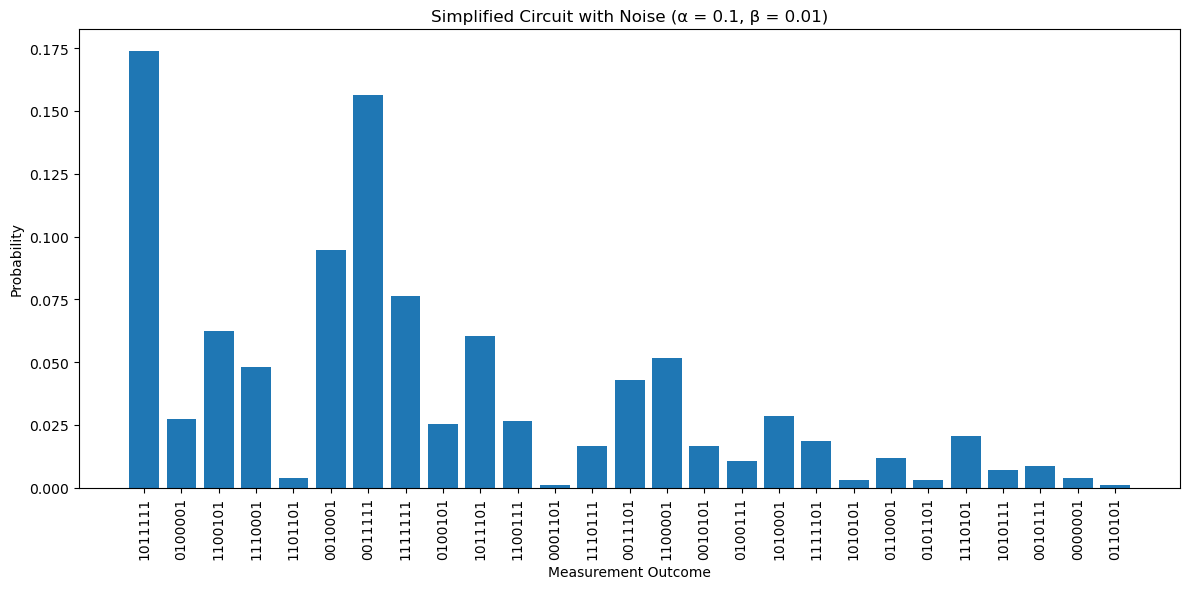

ClassicalRegister(7, 'sum')
Results with α = 0.1, β = 0.05:
Binary: 0010111, Count: 29, Decimal a(30) + b(17) = 23
Binary: 1101011, Count: 37, Decimal a(30) + b(17) = 107
Binary: 1100101, Count: 23, Decimal a(30) + b(17) = 101
Binary: 1000111, Count: 1, Decimal a(30) + b(17) = 71
Binary: 1111011, Count: 76, Decimal a(30) + b(17) = 123
Binary: 0110101, Count: 2, Decimal a(30) + b(17) = 53
Binary: 0101011, Count: 51, Decimal a(30) + b(17) = 43
Binary: 0011101, Count: 14, Decimal a(30) + b(17) = 29
Binary: 1100001, Count: 1, Decimal a(30) + b(17) = 97
Binary: 1111111, Count: 5, Decimal a(30) + b(17) = 127
Binary: 0000101, Count: 163, Decimal a(30) + b(17) = 5
Binary: 1011001, Count: 4, Decimal a(30) + b(17) = 89
Binary: 0010101, Count: 156, Decimal a(30) + b(17) = 21
Binary: 1100111, Count: 11, Decimal a(30) + b(17) = 103
Binary: 0011011, Count: 194, Decimal a(30) + b(17) = 27
Binary: 1010101, Count: 8, Decimal a(30) + b(17) = 85
Binary: 0011001, Count: 38, Decimal a(30) + b(17) = 25
Bina

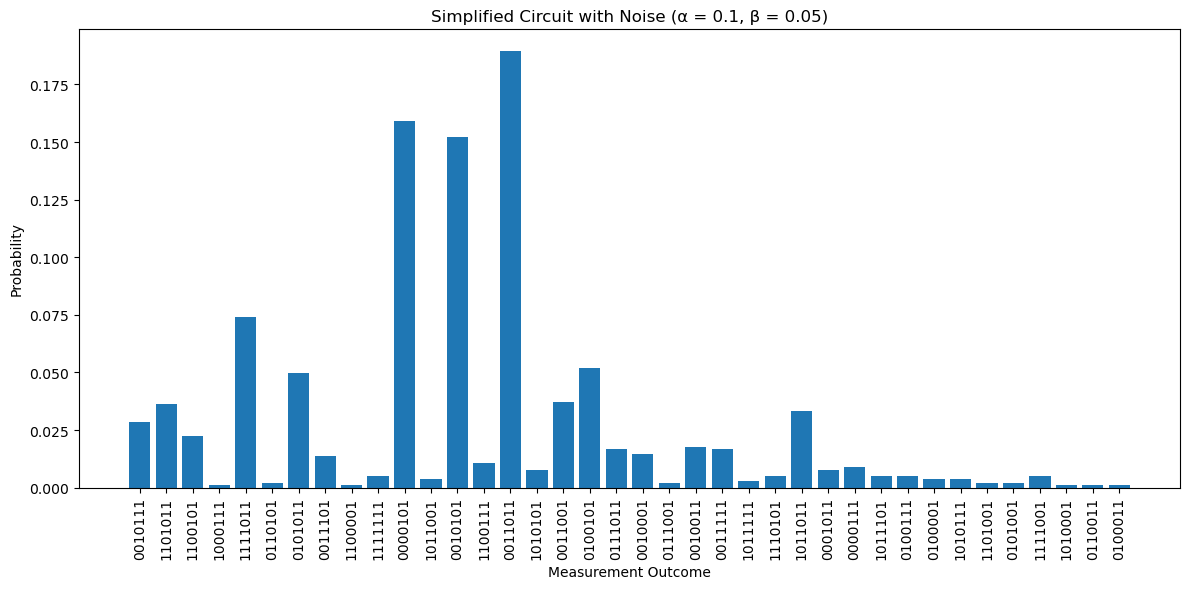

ClassicalRegister(7, 'sum')
Results with α = 0.1, β = 0.1:
Binary: 1001001, Count: 33, Decimal a(30) + b(17) = 73
Binary: 0011111, Count: 41, Decimal a(30) + b(17) = 31
Binary: 1010101, Count: 6, Decimal a(30) + b(17) = 85
Binary: 0011001, Count: 68, Decimal a(30) + b(17) = 25
Binary: 0001001, Count: 64, Decimal a(30) + b(17) = 9
Binary: 0010111, Count: 194, Decimal a(30) + b(17) = 23
Binary: 0101111, Count: 82, Decimal a(30) + b(17) = 47
Binary: 0100101, Count: 51, Decimal a(30) + b(17) = 37
Binary: 1011001, Count: 2, Decimal a(30) + b(17) = 89
Binary: 0010101, Count: 115, Decimal a(30) + b(17) = 21
Binary: 0100111, Count: 33, Decimal a(30) + b(17) = 39
Binary: 0010001, Count: 32, Decimal a(30) + b(17) = 17
Binary: 1101001, Count: 4, Decimal a(30) + b(17) = 105
Binary: 1110101, Count: 5, Decimal a(30) + b(17) = 117
Binary: 0001111, Count: 98, Decimal a(30) + b(17) = 15
Binary: 0101001, Count: 43, Decimal a(30) + b(17) = 41
Binary: 0110101, Count: 23, Decimal a(30) + b(17) = 53
Binary:

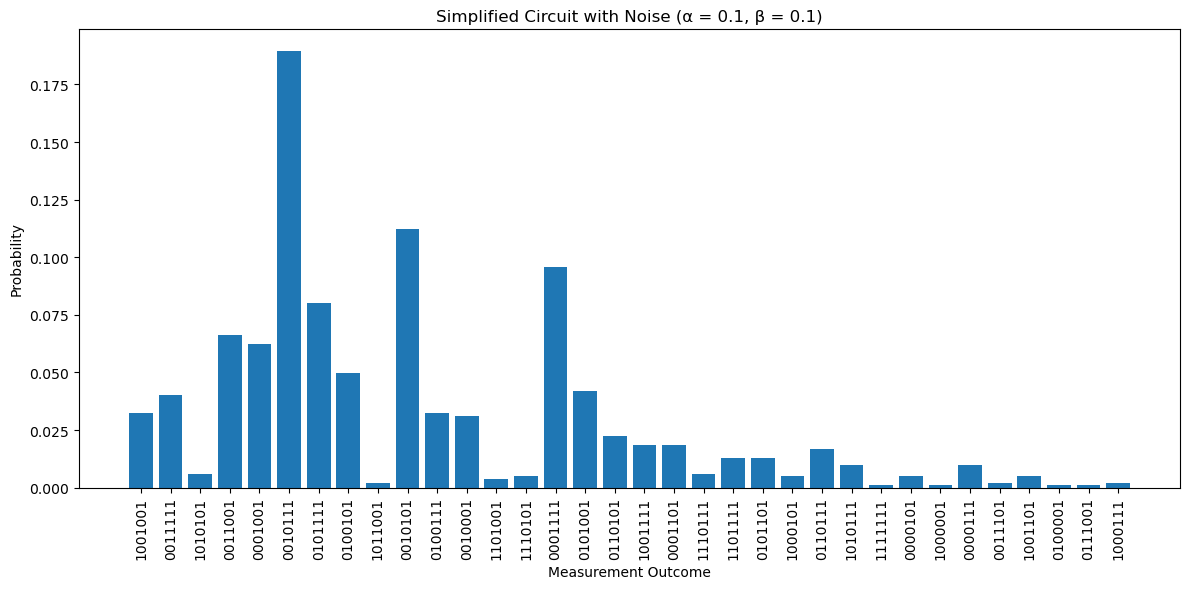

{(0.01, 0.01): {'0101111': 650, '1101111': 374},
 (0.01, 0.05): {'0101001': 12,
  '1100101': 324,
  '1110001': 105,
  '0000101': 30,
  '1101001': 224,
  '1100001': 65,
  '1000001': 32,
  '1000101': 75,
  '1001001': 30,
  '0110101': 25,
  '0110001': 18,
  '1110101': 41,
  '0100101': 11,
  '0000001': 27,
  '0001001': 3,
  '1010101': 2},
 (0.01, 0.1): {'0000110': 24,
  '1111110': 43,
  '0100110': 202,
  '0000010': 64,
  '0100010': 278,
  '0111110': 101,
  '0001110': 38,
  '0110010': 42,
  '0101110': 41,
  '1000010': 124,
  '1001110': 29,
  '1000110': 27,
  '1100010': 5,
  '0010010': 1,
  '1110010': 1,
  '0011110': 3,
  '1100110': 1},
 (0.05, 0.01): {'0110010': 144,
  '0101110': 12,
  '1000100': 10,
  '0000010': 84,
  '0101100': 9,
  '0110100': 62,
  '0100100': 85,
  '1000010': 14,
  '0000100': 119,
  '0110000': 22,
  '0001010': 3,
  '1110010': 128,
  '0100010': 54,
  '1110100': 110,
  '1100010': 12,
  '1100100': 27,
  '0100110': 13,
  '0110110': 5,
  '0101010': 7,
  '1000000': 2,
  '00001

In [12]:
def analyze_noise_effects(a_value, b_value, num_qubits, alpha_values, beta_values):
    """
    Analyze the effect of noise on quantum addition using the Draper adder algorithm.

    Parameters:
    - a_value: Integer value for register A
    - b_value: Integer value for register B
    - num_qubits: Number of qubits for each register A and B
    - alpha_values: List of values for α (probability of one-qubit gate noise)
    - beta_values: List of values for β (probability of two-qubit gate noise)
    """
    # Step 1: Generate the initial quantum sum circuit without noise
    original_circuit = quantum_sum_with_return(a_value, b_value, num_qubits)
    
    # Step 2: Transform the circuit to the specified gate basis
    transformed_circuit = transform_to_basis(original_circuit)
    
    results = {}

    # Step 3: Apply noise and simulate the circuit for each α and β combination
    for alpha in alpha_values:
        for beta in beta_values:
            # Add noise to the circuit with the current alpha and beta values
            noisy_circuit = add_noise_to_circuit(transformed_circuit, alpha, beta)
            simulator = Aer.get_backend('qasm_simulator')
            result = simulator.run(noisy_circuit, shots=1024).result()
            counts = result.get_counts(noisy_circuit)

            # Record the results
            results[(alpha, beta)] = counts
            
            # Display the results
            print(f"Results with α = {alpha}, β = {beta}:")
            for binary_result, count in counts.items():
                decimal_result = int(binary_result, 2)
                print(f"Binary: {binary_result}, Count: {count}, Decimal a({a_value}) + b({b_value}) = {decimal_result}")
            
            # Plot the custom histogram 
            plot_custom_histogram(counts, title=f"Simplified Circuit with Noise (α = {alpha}, β = {beta})")

    return results

# Example values for alpha and beta
alpha_values = [0.01, 0.05, 0.1]
beta_values = [0.01, 0.05, 0.1]


analyze_noise_effects(a_value=30, b_value=17, num_qubits=6, alpha_values=alpha_values, beta_values=beta_values)


# Question and Answer



●	How does the noise affect the results?

$Answer:$
 As seen above without noise, we would expect a single peak representing the correct sum as the primary outcome.
According to the histograms, introducing noise causes the measurement results to spread across multiple outcomes, diluting the peak probability associated with the correct answer.
Higher values of alpha and beta further disrupt the circuit. At higher noise levels, there is a more significant distribution of probabilities across a broader range of measurement outcomes, indicating a loss of information fidelity.

●	Is there a way to decrease the effect of noise? 

$Answer:$ 

With low noise (alpha=0.01,beta=0.01), there is still a clear peak around the correct sum, although some noise-induced states appear.
Increasing alpha or beta individually (example: alpha=0.01,beta=0.1) begins to introduce more incorrect results but may still retain a close peak for the correct answer.
When both alpha and beta are high (example: alpha=0.1,beta=0.1), the probability of the correct outcome diminishes, while wrong results become much more likely.

Some strategies to reduce Noise Effects includes:

    > Error Correction: Implementing quantum error-correcting codes can detect and correct errors caused by noise. This approach requires additional qubits but can significantly improve reliability of the computation.
    > Circuit Optimization: Reducing the number of gates by optimizing the circuit structure or using more efficient quantum addition methods decreases the circuit’s exposure to noise. Fewer operations mean fewer opportunities for noise to disrupt the computation.
    > Using High Quality Control Electronics and Cryogenic Cooling: Using high-precision control electronics reduces the errors introduced during gate operations and cryogenically cooling the system minimizes thermal noise. This helps maintain qubit coherence, extending their stable operational time.

●	How does the number of gates used affect the results? 

$Answer:$ 

The quantum addition circuit uses multiple gates and controlled operations, which increases susceptibility to noise. As more gates are added, noise compounds, causing errors to accumulate. This is evident in the progressively dispersed measurement results with higher noise.
    Reducing the number of gates or designing more noise resilient circuits could improve fidelity, particularly for longer computations.


